In [2]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [3]:
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   
session = tf.Session(config=config)
KTF.set_session(session)

Using TensorFlow backend.


In [4]:
import keras 
from models.psenet import psenet

In [5]:
shape = (None,None,3)

In [6]:
inputs = keras.layers.Input(shape=shape)
output = psenet(inputs)
model  = keras.models.Model(inputs,output)
model.summary()

/anaconda3/envs/tf/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]           

activation_48 (Activation)      (None, None, None, 5 0           bn5c_branch2b[0][0]              
__________________________________________________________________________________________________
res5c_branch2c (Conv2D)         (None, None, None, 2 1050624     activation_48[0][0]              
__________________________________________________________________________________________________
bn5c_branch2c (BatchNormalizati (None, None, None, 2 8192        res5c_branch2c[0][0]             
__________________________________________________________________________________________________
add_16 (Add)                    (None, None, None, 2 0           bn5c_branch2c[0][0]              
                                                                 activation_46[0][0]              
__________________________________________________________________________________________________
activation_49 (Activation)      (None, None, None, 2 0           add_16[0][0]                     
__________

In [6]:
from keras.optimizers import Adam
from models.loss import build_loss
from models.metrics import build_iou,mean_iou
from keras.utils import multi_gpu_model

In [ ]:
parallel_model = multi_gpu_model(model)

In [ ]:
adam = Adam(1e-4)

In [9]:
ious = build_iou([0,1],['bk','txt'])

In [10]:
parallel_model.compile(loss=build_loss,
              optimizer=adam,
              metrics=ious)

In [11]:
import config 
from tool.generator import Generator

In [12]:
train_dir = config.MIWI_2018_TRAIN_LABEL_DIR
test_dir = config.MIWI_2018_TEST_LABEL_DIR
batch_size = 4
num_class =2 
shape = (640,640)

In [13]:
gen_train = Generator(train_dir,batch_size = batch_size ,istraining=True,num_classes=num_class,mirror = False,reshape=shape)

In [14]:
gen_test = Generator(test_dir,batch_size = batch_size ,istraining=False,num_classes=num_class,
                     reshape=shape,mirror=False,scale=False,clip=False,trans_color=False)

In [15]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
checkpoint = ModelCheckpoint(r'resent50-190219_BLINEAR-{epoch:02d}.hdf5',
                           save_weights_only=True)
tb = TensorBoard(log_dir='./logs', update_freq=10)

In [16]:
res = parallel_model.fit_generator(gen_train,
                          steps_per_epoch =gen_train.num_samples()// batch_size,
                          epochs = 40,
                          validation_data=gen_test,
                          validation_steps =gen_test.num_samples()//batch_size,
                          verbose=1,
                          initial_epoch=0,
                          workers=4,
                          max_queue_size=16,
                          callbacks=[checkpoint,tb])

Epoch 1/40
2255/2255 [==============================] - 2021s 896ms/step - loss: 0.2130 - iou_bk: 0.9275 - iou_txt: 0.6898 - val_loss: 0.1418 - val_iou_bk: 0.9499 - val_iou_txt: 0.7825
Epoch 2/40
2255/2255 [==============================] - 1998s 886ms/step - loss: 0.1731 - iou_bk: 0.9404 - iou_txt: 0.7373 - val_loss: 0.1311 - val_iou_bk: 0.9544 - val_iou_txt: 0.7960
Epoch 3/40
2255/2255 [==============================] - 2004s 889ms/step - loss: 0.1666 - iou_bk: 0.9429 - iou_txt: 0.7453 - val_loss: 0.1379 - val_iou_bk: 0.9509 - val_iou_txt: 0.7877
Epoch 4/40
2255/2255 [==============================] - 1988s 881ms/step - loss: 0.1573 - iou_bk: 0.9458 - iou_txt: 0.7576 - val_loss: 0.1264 - val_iou_bk: 0.9548 - val_iou_txt: 0.7924
Epoch 5/40
2255/2255 [==============================] - 1998s 886ms/step - loss: 0.1532 - iou_bk: 0.9470 - iou_txt: 0.7641 - val_loss: 0.1187 - val_iou_bk: 0.9585 - val_iou_txt: 0.8127
Epoch 6/40
2255/2255 [==============================] - 1992s 884ms/step - 

In [ ]:

parallel_model.optimizer.lr = 1e-5
res = parallel_model.fit_generator(gen_train,
                          steps_per_epoch =gen_train.num_samples()// batch_size,
                          epochs = 70,
                          validation_data=gen_test,
                          validation_steps =gen_test.num_samples()//batch_size,
                          verbose=1,
                          initial_epoch=37,
                          workers=4,
                          max_queue_size=16,
                          callbacks=[checkpoint,tb])

In [19]:
parallel_model.optimizer.lr = 1e-6
res = parallel_model.fit_generator(gen_train,
                          steps_per_epoch =gen_train.num_samples()// batch_size,
                          epochs = 150,
                          validation_data=gen_test,
                          validation_steps =gen_test.num_samples()//batch_size,
                          verbose=1,
                          initial_epoch=70,
                          workers=4,
                          max_queue_size=16,
                          callbacks=[checkpoint,tb])

Epoch 71/150
2255/2255 [==============================] - 2020s 896ms/step - loss: 0.0888 - iou_bk: 0.9682 - iou_txt: 0.8549 - val_loss: 0.0912 - val_iou_bk: 0.9673 - val_iou_txt: 0.8504
Epoch 72/150
2255/2255 [==============================] - 1989s 882ms/step - loss: 0.0878 - iou_bk: 0.9688 - iou_txt: 0.8565 - val_loss: 0.0895 - val_iou_bk: 0.9682 - val_iou_txt: 0.8525
Epoch 73/150
2255/2255 [==============================] - 1999s 886ms/step - loss: 0.0879 - iou_bk: 0.9690 - iou_txt: 0.8567 - val_loss: 0.0905 - val_iou_bk: 0.9675 - val_iou_txt: 0.8499
Epoch 74/150
2255/2255 [==============================] - 2019s 895ms/step - loss: 0.0898 - iou_bk: 0.9686 - iou_txt: 0.8532 - val_loss: 0.0920 - val_iou_bk: 0.9670 - val_iou_txt: 0.8502
Epoch 75/150
2255/2255 [==============================] - 1995s 884ms/step - loss: 0.0879 - iou_bk: 0.9686 - iou_txt: 0.8568 - val_loss: 0.0890 - val_iou_bk: 0.9681 - val_iou_txt: 0.8541
Epoch 76/150
2255/2255 [==============================] - 2003s 8

C:\Program Files\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.838847). Check your callbacks.
  % delta_t_median)


2255/2255 [==============================] - 1997s 886ms/step - loss: 0.0885 - iou_bk: 0.9684 - iou_txt: 0.8555 - val_loss: 0.0876 - val_iou_bk: 0.9687 - val_iou_txt: 0.8558
Epoch 84/150
2255/2255 [==============================] - 2003s 888ms/step - loss: 0.0874 - iou_bk: 0.9696 - iou_txt: 0.8574 - val_loss: 0.0864 - val_iou_bk: 0.9694 - val_iou_txt: 0.8579
Epoch 85/150
2255/2255 [==============================] - 1991s 883ms/step - loss: 0.0850 - iou_bk: 0.9705 - iou_txt: 0.8616 - val_loss: 0.0856 - val_iou_bk: 0.9697 - val_iou_txt: 0.8587
Epoch 86/150
2255/2255 [==============================] - 1990s 883ms/step - loss: 0.0861 - iou_bk: 0.9694 - iou_txt: 0.8593 - val_loss: 0.0872 - val_iou_bk: 0.9683 - val_iou_txt: 0.8557
Epoch 87/150
2255/2255 [==============================] - 2021s 896ms/step - loss: 0.0861 - iou_bk: 0.9694 - iou_txt: 0.8597 - val_loss: 0.0903 - val_iou_bk: 0.9679 - val_iou_txt: 0.8536
Epoch 88/150
2255/2255 [==============================] - 2001s 887ms/step - l

C:\Program Files\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.987048). Check your callbacks.
  % delta_t_median)


2255/2255 [==============================] - 2011s 892ms/step - loss: 0.0853 - iou_bk: 0.9699 - iou_txt: 0.8606 - val_loss: 0.0872 - val_iou_bk: 0.9693 - val_iou_txt: 0.8554
Epoch 94/150
2255/2255 [==============================] - 1987s 881ms/step - loss: 0.0836 - iou_bk: 0.9710 - iou_txt: 0.8640 - val_loss: 0.0851 - val_iou_bk: 0.9697 - val_iou_txt: 0.8589
Epoch 95/150
2255/2255 [==============================] - 2002s 888ms/step - loss: 0.0846 - iou_bk: 0.9702 - iou_txt: 0.8622 - val_loss: 0.0860 - val_iou_bk: 0.9692 - val_iou_txt: 0.8586
Epoch 96/150
2255/2255 [==============================] - 2007s 890ms/step - loss: 0.0857 - iou_bk: 0.9697 - iou_txt: 0.8602 - val_loss: 0.0937 - val_iou_bk: 0.9668 - val_iou_txt: 0.8511
Epoch 97/150
2255/2255 [==============================] - 1998s 886ms/step - loss: 0.0844 - iou_bk: 0.9705 - iou_txt: 0.8624 - val_loss: 0.0866 - val_iou_bk: 0.9694 - val_iou_txt: 0.8587
Epoch 98/150
2255/2255 [==============================] - 2003s 888ms/step - l

KeyboardInterrupt: 

In [20]:
#model.load_weights('resent50-29.hdf5')
parallel_model.load_weights('resent50-190219_BLINEAR-102.hdf5')
model.save_weights('resent50-190219_BLINEAR-iou8604.hdf5')
model.load_weights('resent50-190219_BLINEAR-iou8604.hdf5')

In [7]:
model.load_weights('./tf/resnet50.hdf5')

In [8]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import tqdm
#dir = r'C:\jianweidata\ocr\psenet\Extraction Test\2x'
dir = r'E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test'
imagesfile = glob.glob(os.path.join(dir,'*.jpg'))
MIN_LEN = 640
MAX_LEN = 1024

In [10]:
from tool.utils import ufunc_4 , scale_expand_kernels ,fit_minarearectange,fit_boundingRect,save_MTWI_2108_resault
with tqdm.tqdm(total = len(imagesfile)) as bar:
    for i,j in enumerate(imagesfile):
                bar.update()
                #j = r'E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test\T1..67FbxfXXXXXXXX_!!0-item_pic.jpg.jpg'
                images=cv2.imdecode(np.fromfile(j,dtype=np.uint8),-1) 
                #images=cv2.cvtColor(images,cv2.COLOR_RGB2BGR)
                
                h,w = images.shape[0:2]
#                 if(h>w and h>MAX_LEN):
#                     w = MAX_LEN / h * w   
#                     h = MAX_LEN
#                 elif(w>=h and w>MAX_LEN):
#                     h = MAX_LEN / w * h   
#                     w = MAX_LEN

                if(w<h and w<MIN_LEN):
                    h = MIN_LEN / w * h               
                    w = MIN_LEN
                elif(h<=w and h<MIN_LEN):
                    w = MIN_LEN / h * w         
                    h = MIN_LEN
                    
                w = min(w,MAX_LEN)    
                h = min(h,MAX_LEN)
                
                
                w = int(w //32 * 32)
                h = int(h//32 * 32)
                
#                 w = 640
#                 h = 640 
                scalex = images.shape[1] / w
                scaley = images.shape[0] / h
                
                images = cv2.resize(images,(w,h),cv2.INTER_AREA)
                images = np.reshape(images,(1,h,w,3))            
                
                res = model.predict(images)
                res1 = res[0]
                res1[res1>0.9]= 1
                res1[res1<=0.9]= 0
                newres1 = []
                for i in range(5):
                    n = np.logical_and(res1[:,:,5],res1[:,:,i]) * 255
                    newres1.append(n)
                newres1.append(res1[:,:,5]*255)
                num_label,labelimage = scale_expand_kernels(newres1)
                rects = fit_minarearectange(num_label,labelimage)

                
                cv2.drawContours(images[0],np.array(rects)*2,-1,(0,0,255),2)
                
                base_name = '.'.join(os.path.basename(j).split('.')[:-1])
                cv2.imwrite(os.path.join(dir,base_name+'_6.tif'),images[0])
                
                save_MTWI_2108_resault(os.path.join(dir,base_name+'.txt'),np.array(rects)*2,scalex ,scaley)

0it [00:00, ?it/s]


In [9]:

#images = cv2.imread('E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test\TB107c7ejgy_uJjSZJnCczuOXXa.jpg')
img_file = '/Users/mahuichao/Documents/tmp/客户测试/文档/表格测试/image/1573711730734.jpg'
imgsrc = cv2.imread(img_file)
h,w = imgsrc.shape[0:2]
images = np.copy(imgsrc)

MIN_LEN = 32
MAX_LEN = 1800
h, w = images.shape[0:2]
if(w<h):
    if(w<MIN_LEN):
        scale = 1.0 * MIN_LEN / w
        h = h * scale 
        w = MIN_LEN
    elif(h>MAX_LEN):
        scale = 1.0 * MAX_LEN / h 
        w = w * scale if w * scale > MIN_LEN else MIN_LEN
        h = MAX_LEN
elif(h<=w ):
    if(h<MIN_LEN):
        scale = 1.0 * MIN_LEN / h
        w = scale * w
        h = MIN_LEN 
    elif(w>MAX_LEN):
        scale = 1.0 * MAX_LEN / w
        h = scale * h if scale * h >  MIN_LEN else MIN_LEN
        w = MAX_LEN

w = int(w //32 * 32)
h = int(h//32 * 32)

scalex = images.shape[1] / w
scaley = images.shape[0] / h

images = cv2.resize(images,(w,h),cv2.INTER_AREA)
images = np.reshape(images,(1,h,w,3))   


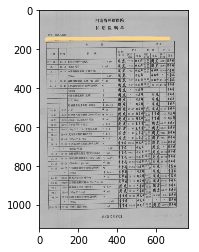

In [10]:
plt.imshow(images[0])

In [11]:
%time res = model.predict(images[0:1,:,:,:])

CPU times: user 49.9 s, sys: 3.07 s, total: 53 s
Wall time: 17.4 s


In [12]:
res1 = res[0]
res1[res1>0.5]= 1
res1[res1<=0.5]= 0
newres1 = []
for i in range(0,5):
    n = np.logical_and(res1[:,:,5],res1[:,:,i]) * 255
    n = n.astype('int32')
    newres1.append(n)
newres1.append((res1[:,:,5]*255).astype('int32'))

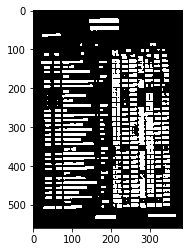

In [13]:
plt.imshow(newres1[-1],cmap='gray')

In [14]:
newres1[0].shape
cv2.imwrite('./tmp/roate.jpg',newres1[-1])

True

In [15]:
from tool.utils import ufunc_4 , scale_expand_kernels , fit_boundingRect_cpp ,fit_minarearectange_cpp
from tool.utils import text_porposcal , order_points,fit_boundingRect_warp_cpp,fit_boundingRect_cpp


In [16]:
%time num_label,labelimage = scale_expand_kernels(newres1,filter=False)

CPU times: user 24.9 ms, sys: 2.38 ms, total: 27.2 ms
Wall time: 27.3 ms


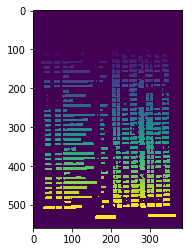

In [17]:
plt.imshow(labelimage)

In [18]:
print(labelimage.shape)

(560, 384)


In [19]:
%time rects = fit_boundingRect_cpp(num_label-1,labelimage)

CPU times: user 20.7 ms, sys: 2.5 ms, total: 23.2 ms
Wall time: 34.4 ms


In [20]:
#cell_lines = [(184, 2204, 184, 2162), (190, 2075, 190, 2037), (490, 2075, 490, 1821), (927, 2075, 927, 1744), (491, 1820, 491, 1712), (928, 1743, 928, 1711), (273, 2075, 273, 1711), (1445, 2074, 1445, 1612), (275, 1654, 275, 1503), (494, 1654, 494, 1345), (878, 1055, 878, 1026), (496, 1344, 496, 974), (278, 1502, 278, 909), (1454, 1611, 1454, 617), (934, 1654, 934, 617), (500, 975, 500, 617), (282, 908, 282, 617), (196, 2036, 196, 616), (1583, 288, 1583, 256), (1588, 288, 1588, 224), (1471, 2135, 1471, 152), (182, 2135, 182, 150)]
#cell_lines = [(939,792,939,680)]
cell_lines = []
cell_lines = [[x2/scalex/2,y2/scaley/2,x1/scalex/2,y1/scaley/2] for x1,y1,x2,y2 in cell_lines]
print(cell_lines)

[]


In [21]:
g = text_porposcal(rects,max_dist=20,threshold_overlap_v=0.5)
rects = g.get_text_line_split_cell(cell_lines)
rects = np.array(rects)
rects[:,:,0] *= 2
rects[:,:,1] *= 2


AttributeError: 'text_porposcal' object has no attribute 'get_text_line_split_cell'

In [ ]:
imagetest = np.copy(images[0])
cell_lines = np.array(cell_lines).astype(np.int32)
for cell_line in cell_lines:
    cv2.line(imagetest,(cell_line[0]*2,cell_line[1]*2),(cell_line[2]*2,cell_line[3]*2),(0,255,0),2)
for rt in rects:
    cv2.drawContours(imagetest,[rt],-1,(0,0,255),2)



In [ ]:
plt.imshow(imagetest)
cv2.imwrite('./tmp/t5.jpg',imagetest)

In [ ]:
## todo
* 大概有100张图片没读出来 Y
* 把评测代码加上       
* 换backone
* 弧形文本行
* 强交叉文本行
* 误检太多

## 转pb

In [ ]:

saver = tf.train.Saver()
saver.save(KTF.get_session(),r'./tf/resnet50.ckpt')

In [33]:
n = [print(n.name) for n in tf.get_default_graph().as_graph_def().node]

input_1
lambda_1/MeanSubstraction/y
lambda_1/MeanSubstraction
conv1_pad/Pad/paddings
conv1_pad/Pad
conv1/truncated_normal/shape
conv1/truncated_normal/mean
conv1/truncated_normal/stddev
conv1/truncated_normal/TruncatedNormal
conv1/truncated_normal/mul
conv1/truncated_normal
conv1/kernel
conv1/kernel/Assign
conv1/kernel/read
conv1/Const
conv1/bias
conv1/bias/Assign
conv1/bias/read
conv1/convolution/dilation_rate
conv1/convolution
conv1/BiasAdd
bn_conv1/Const
bn_conv1/gamma
bn_conv1/gamma/Assign
bn_conv1/gamma/read
bn_conv1/Const_1
bn_conv1/beta
bn_conv1/beta/Assign
bn_conv1/beta/read
bn_conv1/Const_2
bn_conv1/moving_mean
bn_conv1/moving_mean/Assign
bn_conv1/moving_mean/read
bn_conv1/Const_3
bn_conv1/moving_variance
bn_conv1/moving_variance/Assign
bn_conv1/moving_variance/read
bn_conv1/IsVariableInitialized
bn_conv1/IsVariableInitialized_1
bn_conv1/IsVariableInitialized_2
bn_conv1/IsVariableInitialized_3
bn_conv1/IsVariableInitialized_4
bn_conv1/IsVariableInitialized_5
bn_conv1/init
bn_c

res3a_branch2a/truncated_normal/mean
res3a_branch2a/truncated_normal/stddev
res3a_branch2a/truncated_normal/TruncatedNormal
res3a_branch2a/truncated_normal/mul
res3a_branch2a/truncated_normal
res3a_branch2a/kernel
res3a_branch2a/kernel/Assign
res3a_branch2a/kernel/read
res3a_branch2a/Const
res3a_branch2a/bias
res3a_branch2a/bias/Assign
res3a_branch2a/bias/read
res3a_branch2a/convolution/dilation_rate
res3a_branch2a/convolution
res3a_branch2a/BiasAdd
bn3a_branch2a/Const
bn3a_branch2a/gamma
bn3a_branch2a/gamma/Assign
bn3a_branch2a/gamma/read
bn3a_branch2a/Const_1
bn3a_branch2a/beta
bn3a_branch2a/beta/Assign
bn3a_branch2a/beta/read
bn3a_branch2a/Const_2
bn3a_branch2a/moving_mean
bn3a_branch2a/moving_mean/Assign
bn3a_branch2a/moving_mean/read
bn3a_branch2a/Const_3
bn3a_branch2a/moving_variance
bn3a_branch2a/moving_variance/Assign
bn3a_branch2a/moving_variance/read
bn3a_branch2a/Const_4
bn3a_branch2a/Const_5
bn3a_branch2a/FusedBatchNorm
bn3a_branch2a/Shape
bn3a_branch2a/strided_slice/stack


bn3d_branch2b/moving_mean/biased
bn3d_branch2b/moving_mean/biased/Assign
bn3d_branch2b/moving_mean/biased/read
bn3d_branch2b/moving_mean/local_step/Initializer/zeros
bn3d_branch2b/moving_mean/local_step
bn3d_branch2b/moving_mean/local_step/Assign
bn3d_branch2b/moving_mean/local_step/read
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/sub
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/mul
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/bn3d_branch2b/moving_mean
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/AssignAdd/value
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/AssignAdd
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/read
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/sub_1/x
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/sub_1
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/read_1
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/Pow
bn3d_branch2b/AssignMovingAvg/bn3d_branch2b/moving_mean/sub_2

bn4d_branch2a/moving_mean/local_step/Assign
bn4d_branch2a/moving_mean/local_step/read
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/mul
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/bn4d_branch2a/moving_mean
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/AssignAdd/value
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/AssignAdd
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/read
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub_1/x
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub_1
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/read_1
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/Pow
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub_2/x
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub_2
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/truediv
bn4d_branch2a/AssignMovingAvg/bn4d_branch2a/moving_mean/sub_3
bn4d_branch2

res5c_branch2c/truncated_normal/mul
res5c_branch2c/truncated_normal
res5c_branch2c/kernel
res5c_branch2c/kernel/Assign
res5c_branch2c/kernel/read
res5c_branch2c/Const
res5c_branch2c/bias
res5c_branch2c/bias/Assign
res5c_branch2c/bias/read
res5c_branch2c/convolution/dilation_rate
res5c_branch2c/convolution
res5c_branch2c/BiasAdd
bn5c_branch2c/Const
bn5c_branch2c/gamma
bn5c_branch2c/gamma/Assign
bn5c_branch2c/gamma/read
bn5c_branch2c/Const_1
bn5c_branch2c/beta
bn5c_branch2c/beta/Assign
bn5c_branch2c/beta/read
bn5c_branch2c/Const_2
bn5c_branch2c/moving_mean
bn5c_branch2c/moving_mean/Assign
bn5c_branch2c/moving_mean/read
bn5c_branch2c/Const_3
bn5c_branch2c/moving_variance
bn5c_branch2c/moving_variance/Assign
bn5c_branch2c/moving_variance/read
bn5c_branch2c/Const_4
bn5c_branch2c/Const_5
bn5c_branch2c/FusedBatchNorm
bn5c_branch2c/Shape
bn5c_branch2c/strided_slice/stack
bn5c_branch2c/strided_slice/stack_1
bn5c_branch2c/strided_slice/stack_2
bn5c_branch2c/strided_slice
bn5c_branch2c/Shape_1
bn

batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/read_1
batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/Pow
batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/sub_2/x
batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/sub_2
batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/truediv
batch_normalization_4/AssignMovingAvg_1/batch_normalization_4/moving_variance/sub_3
batch_normalization_4/AssignMovingAvg_1
batch_normalization_4/cond/Switch
batch_normalization_4/cond/switch_t
batch_normalization_4/cond/switch_f
batch_normalization_4/cond/pred_id
batch_normalization_4/cond/Switch_1
batch_normalization_4/cond/FusedBatchNorm
batch_normalization_4/cond/FusedBatchNorm/Switch
batch_normalization_4/cond/FusedBatchNorm/Switch_1
batch_normalization_4/cond/FusedBatchNorm/Switch_2
batch_normalization_4/cond/FusedBatchNorm/Switch_3
batch_normalization_4/cond/Fused

In [34]:
from tensorflow.python.tools import freeze_graph
freeze_graph.freeze_graph(input_checkpoint = './tf/resnet50.ckpt',
                          input_meta_graph = './tf/resnet50.ckpt.meta',
                          output_graph = 'psenet.pb',
                          output_node_names = 'activation_55/Sigmoid',
                          clear_devices = True,
                          input_graph ='',
                          input_saver = '',
                          input_binary = True,
                          restore_op_name = 'save/restore_all',
                          filename_tensor_name = 'save/Const:0',
                          initializer_nodes = '')

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
sess = None
with tf.Graph().as_default():
    output_graph_def = tf.GraphDef()
    with open('psenet.pb','rb') as f :
        output_graph_def.ParseFromString(f.read())
        _= tf.import_graph_def(output_graph_def,name='')
        
    sess =  tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    ip = sess.graph.get_tensor_by_name("input_1:0")
    op = sess.graph.get_tensor_by_name("activation_55/Sigmoid:0")



In [ ]:
MIN_LEN = 640
MAX_LEN = 1500
images = cv2.imread(r'./r1.png')
h,w = images.shape[0:2]

if(w<h):
    if(h<MIN_LEN):
        scale = 1.0 * MIN_LEN / h
        w = w * scale 
        h = MIN_LEN
    elif(h>MAX_LEN):
        scale = 1.0 * MAX_LEN / h 
        w = w * scale 
        h = MAX_LEN
elif(h<=w ):
    if(w<MIN_LEN):
        scale = 1.0 * MIN_LEN /w
        h = scale * h 
        w = MIN_LEN 
    elif(w>MAX_LEN):
        scale = 1.0 * MAX_LEN /w
        h = scale * w 
        h = MAX_LEN
        
w = int(w //32 * 32)
h = int(h//32 * 32)

scalex = images.shape[1] / w
scaley = images.shape[0] / h

images = cv2.resize(images,(w,h),cv2.INTER_AREA)
images = np.reshape(images,(1,h,w,3))   


res = sess.run([op], feed_dict={ip:images})



In [ ]:
res1 = res[0][0]
print(res1.shape)
res1[res1>0.9]= 1
res1[res1<=0.9]= 0
newres1 = []
for i in range(3,5):
    n = np.logical_and(res1[:,:,5],res1[:,:,i]) * 255
    newres1.append(n)
newres1.append(res1[:,:,5]*255)     

from tool.utils import scale_expand_kernels ,fit_boundingRect_2
from tool.utils import text_porposcal

num_label,labelimage = scale_expand_kernels(newres1,filter=False)
rects = fit_boundingRect_2(num_label,labelimage)

g = text_porposcal(rects,labelimage.shape[1],max_dist=3,threshold_overlap_v=0.3)
rects = g.get_text_line()

imagetest = np.copy(images[0])

for rt in rects:
    cv2.rectangle(imagetest,(rt[0]*2,rt[1]*2-2),(rt[2]*2,rt[3]*2),(0,0,255),2)
plt.imshow(imagetest)
cv2.imwrite('test7.jpg',imagetest)

In [ ]:
import numpy as np 

a = [0] + [1,2,3]

In [ ]:
a = np.array(a) / np.sum(a)

In [ ]:
a = np.cumsum(a) * 10 

In [ ]:
a[-1] = 10

In [ ]:
a

In [100]:
import os 
os.mkdir('Users/mahuichao/Documents/TableBank_data/Detection_data/Word/train_0')


FileNotFoundError: [Errno 2] No such file or directory: 'Users/mahuichao/Documents/TableBank_data/Detection_data/Word/train_0'

In [255]:
from collections import Counter

In [286]:
a = Counter([])


In [287]:
a

Counter()

In [288]:
b = a.most_common(1)

In [26]:
b  = np.array([])

In [27]:
b = b-0

In [28]:
b


array([], dtype=float64)